Projeto de predição de grau de estado deterioração do figado devido ao HCV

Equipe: Daniel Lemos,
        Rafael Targino
        
Data_Set: https://archive.ics.uci.edu/ml/machine-learning-databases/00503/HCV-Egy-Data.zip


Passos:
Ler os dados e normalizá-los cross-validation 10 folds
Utilizar os seguintes algoritimos:
1- KNN variando o K(1,3,5,10)
2- Naive-Bayes
3- Arvore de Decisão (Random Forrest) variando o numero de florestas
4- RLScore(variando o numero de kernels)

In [1]:
!pip install rlscore
import numpy as np
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

     |████████████████████████████████| 788kB 2.9MB/s 
  Created wheel for rlscore: filename=rlscore-0.8.1-cp36-cp36m-linux_x86_64.whl size=1824842 sha256=75abc9c1b41dfe7d912d381ceb34e9fca155bda10b0347402d0f6dbeb2c4ab92
  Stored in directory: /root/.cache/pip/wheels/96/d7/27/cd7b2182c3f5c012dbbf9a8507116b9c49140ffc733223c07b
Successfully built rlscore


Base de dados de pacientes egípcios que foram submetidos a doses de tratamento para HCV cerca de 18 meses. A discretização deve ser aplicada com base em recomendações de especialistas; há um arquivo anexado mostra como.

A base de dados reúne cerca de 

Os dados apresentão o estágio inicial da entrada dos pacientes e as taxas , o problema é diagnosticar o grau de degradação do fígado através dos exames previamente levantados, sem a necessidade de exame de ultrasom ou histológico, ou seja prever o resultado do exame histológio acelerando assim que tipo de tratamento aplicar.
as classes são não fibroso que significa saldável, fibroso, fibroso com poucas cepas do vírus, fibroso com muitas cepas e cirrose.


In [0]:
df = pd.read_csv("https://drive.google.com/uc?authuser=0&id=1S2HnHU5zoI7ERYhVd8naSaUMt0eJZW3L&export=download")
columns = df.columns



Preparação dos dados de três formas diferentes, sendo escalados entre 0 e 1, valores absolutos  e normalizados, gerando três dataframes diferentes para os testes, separação das labels do Features.

In [0]:
from sklearn import preprocessing
dfclass = pd.Series(df['Baselinehistological staging'])
dfsclass = pd.DataFrame(df.iloc[:,0:28]) 
columns = dfsclass.columns

repcolumns = list()
for index, column in enumerate(columns):
  column = column.replace(" ","")
  repcolumns.append(column)
x = dfsclass.values
x_scale = preprocessing.scale(dfsclass)
x_normal = preprocessing.normalize(dfsclass, norm='l1')
min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(dfsclass)
x_abs = max_abs_scaler.fit_transform(dfsclass)


dfnorm = pd.DataFrame(x_normal, columns = repcolumns)
df_abs = pd.DataFrame(x_abs, columns = repcolumns)
df_scale = pd.DataFrame(x_scaled, columns = repcolumns)

dfL = []
dfL.append(dfnorm)
dfL.append(df_abs)
dfL.append(df_scale)




Geração dos kfolds

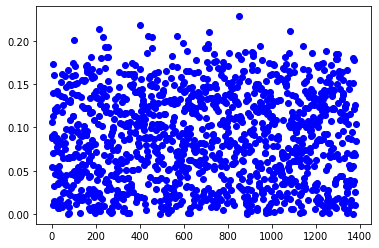

In [37]:

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
X_index = dfnorm.index
Y_index = dfclass.index

Features = next(kf.split(X_index))
Labels = next(kf.split(Y_index))

X_train_N = dfnorm.iloc[Features[0]]
X_test_N = dfnorm.iloc[Features[1]]

X_train_Abs = df_abs.iloc[Features[0]]
X_test_Abs = df_abs.iloc[Features[1]]

X_train_S = df_scale.iloc[Features[0]]
X_test_S = df_scale.iloc[Features[1]]

Y_train = dfclass.iloc[Labels[0]]
Y_test = dfclass.iloc[Labels[1]]

X_trainL = []
X_trainL.append([X_train_N,X_test_N])
X_trainL.append([X_train_Abs,X_test_Abs])
X_trainL.append([X_train_S,X_test_S])


pl.plot(X_train_N['RNA4'],'bo')


In [38]:
from rlscore.learner import RLS
from rlscore.measure import sqerror
from rlscore.learner import LeaveOneOutRLS

regparams = [2.**i for i in range(-15, 16)]
for X_train in X_trainL:
  learner = RLS(X_train[0], Y_train, kernel="PolynomialKernel", regparam = 100, gamma=1.0, coef0=1.0, degree=2)
  P_loo = learner.leave_one_out()
  P_test = learner.predict(X_train[1])
  print("leave-one-out error %f" %sqerror(Y_train, P_loo))
  print("test error %f" %sqerror(Y_test, P_test))
  



/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):
/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):


leave-one-out error 1.291374
test error 1.321862
leave-one-out error 1.297996
test error 1.314215
leave-one-out error 1.343569
test error 1.334558


In [0]:
  regparams = [2.**i for i in range(-15, 16)]
  gammas = regparams
  best_regparam = None
  best_gamma = None
  best_error = float("inf")
  best_learner = None
  for gamma in gammas:
      
      learner = LeaveOneOutRLS(X_train, Y_train, kernel="GaussianKernel", gamma=gamma, regparams=regparams)
      e = np.min(learner.cv_performances)
      if e < best_error:
          best_error = e
          best_regparam = learner.regparam
          best_gamma = gamma
          best_learner = learner
P_test = best_learner.predict(X_test)
print("best parameters gamma %f regparam %f" %(best_gamma, best_regparam))
print("best leave-one-out error %f" %best_error)
print("test error %f" %sqerror(Y_test, P_test))

/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):
/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):


best parameters gamma 0.000031 regparam 1.000000
best leave-one-out error 1.259181
test error 1.257212


Naive-Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


for df in dfL:
  X_train,X_test,Y_train,Y_test = train_test_split(df,dfclass, test_size = 0.3, random_state = 900)
  
  gnb = GaussianNB()

  gnb.fit(X_train, Y_train)

  y_pred = gnb.predict(X_test)

  print('Accuracy GaussianNB: {}'.format(metrics.accuracy_score(Y_test, y_pred)))

  gnb = MultinomialNB()

  gnb.fit(X_train, Y_train)

  y_pred = gnb.predict(X_test)

  print('Accuracy MultinominalNB: {}'.format(metrics.accuracy_score(Y_test, y_pred)))


Accuracy GaussianNB: 0.28125
Accuracy MultinominalNB: 0.24759615384615385
Accuracy GaussianNB: 0.2548076923076923
Accuracy MultinominalNB: 0.27163461538461536
Accuracy GaussianNB: 0.2548076923076923
Accuracy MultinominalNB: 0.28365384615384615


Random Forrest

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


def accuracy(y_true, y_pred):
    acertos=0
    for x in range(0,len(y_true)):
        if y_true[x] == y_pred[x]:
            acertos +=1

    porcentagem = acertos/len(y_true)
    return porcentagem

estimators =[100,200,500,800]



for df in dfL:
  for n in estimators:
    train_features, test_features, train_labels, test_labels = train_test_split(df, dfclass, test_size = 0.25, random_state = 42)
    rf = RandomForestClassifier(n_estimators=n)

    rf.fit(train_features,train_labels)
    predictions = rf.predict(test_features)
    print('Accuracy com estimator {} : {}'.format(n,metrics.accuracy_score(test_labels, predictions)))
  

Accuracy com estimator 100 : 0.3227665706051873
Accuracy com estimator 200 : 0.3025936599423631
Accuracy com estimator 500 : 0.2824207492795389
Accuracy com estimator 800 : 0.30835734870317005
Accuracy com estimator 100 : 0.29394812680115273
Accuracy com estimator 200 : 0.2824207492795389
Accuracy com estimator 500 : 0.26512968299711814
Accuracy com estimator 800 : 0.25936599423631124
Accuracy com estimator 100 : 0.2276657060518732
Accuracy com estimator 200 : 0.2478386167146974
Accuracy com estimator 500 : 0.2478386167146974
Accuracy com estimator 800 : 0.2622478386167147


KNN